# Project Pipeline

Create an environment for the project

i. Download the data
ii. Import the metadata into pandas

iii. Data Exploration 

    age distribution of the disease 
    count base on the part of the body the mole appear
    count base on the form of test 
    count of the cell type
    count base on gender
    count base on location of disease over gender

iv. Preprocess the data by rescaling since the original dimension of images cannot be handle by Tensrflow.


In [74]:
import seaborn as sns
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler 
import numpy as np
from sklearn.model_selection import train_test_split
import os, cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D

In [76]:
base_skin_dir = os.path.join('..', '\\Image')
base_skin_dir 


'\\Image'

In [77]:

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_skin_dir, '*','*.jpg'))} 

In [78]:
len(imageid_path_dict)

0

In [79]:
# Assigning the image and labels to a dictionary
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


In [50]:
#com = r'C:\Users\masud\Documents\Mole_detection\asset\Metadata\HAM10000_metadata.csv'

In [80]:
skin_df = pd.read_csv(os.path.join('base_skin_dir', 'HAM10000_metadata.csv'))

# Creating extra coulmn for better understanding of the column

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

FileNotFoundError: [Errno 2] No such file or directory: 'base_skin_dir\\HAM10000_metadata.csv'

In [52]:
# displayimg the top 5 data
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


#### Data Cleaning 

Determing their number of missing value

Replacing the missing value with the mean of the column

Determine the data types of each column

In [36]:
# Determing their number of missing value

skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                 57
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [38]:
# Filling the missing value with the mean

skin_df["age"].fillna((skin_df["age"].mean()), inplace= True)

# Converting dtype of age to int32
skin_df['age'] = skin_df['age'].astype('int32')


skin_df.isnull().sum()

lesion_id            0
image_id             0
dx                   0
dx_type              0
age                  0
sex                  0
localization         0
path             10015
cell_type            0
cell_type_idx        0
dtype: int64

In [39]:
# print the data type for each column
print(skin_df.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age               int32
sex              object
localization     object
path             object
cell_type        object
cell_type_idx      int8
dtype: object


#### Exploratory Data Analysis

<AxesSubplot:>

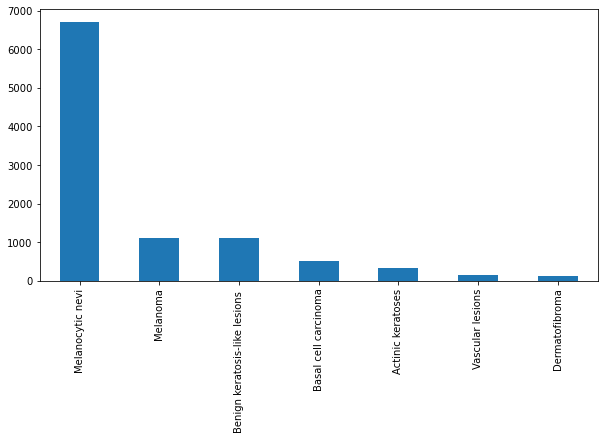

In [40]:
# count of the cell type

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


<AxesSubplot:>

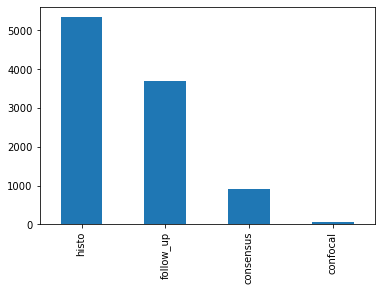

In [41]:
# count base on the form of test 

skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

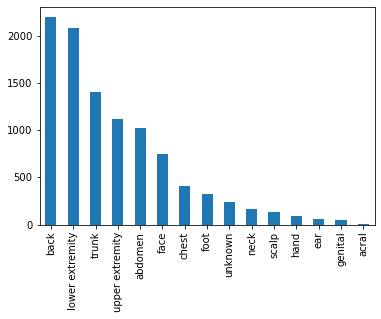

In [42]:
# count base on the part of the body the mole appear


skin_df['localization'].value_counts().plot(kind='bar')

Text(0.5, 1.0, 'Gender of Patient')

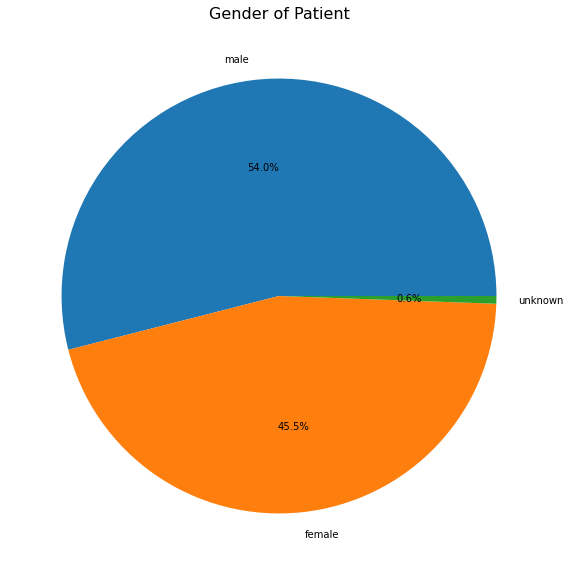

In [43]:
# Gender distributiom

bar, ax = plt.subplots(figsize = (10,10))
plt.pie(skin_df['sex'].value_counts(), labels = skin_df['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

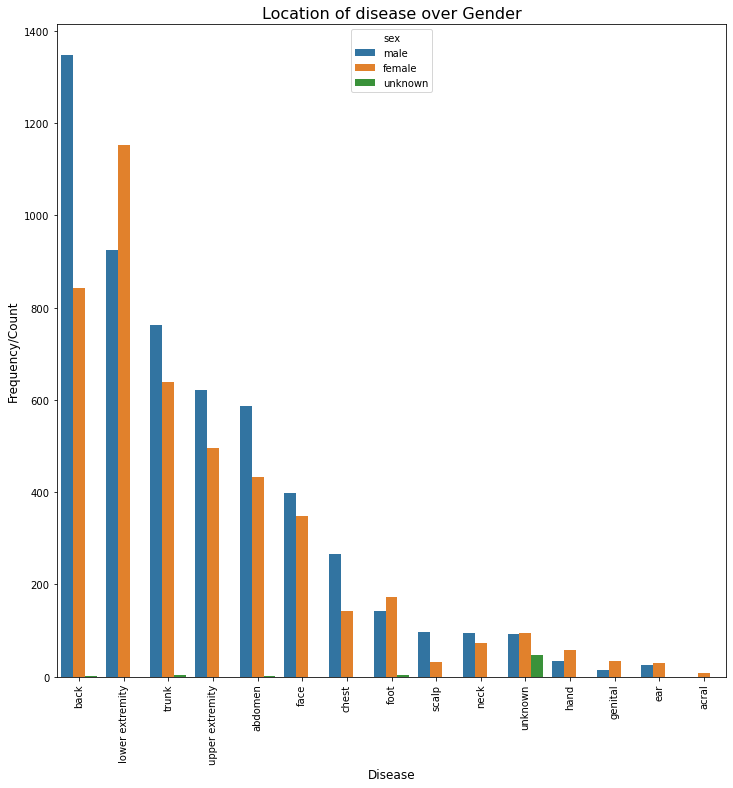

In [44]:
# location of disease over gender 

value = skin_df[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

<AxesSubplot:>

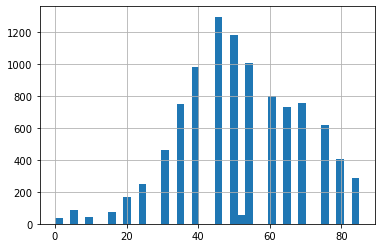

In [ ]:
# Age distribution of the disease 

skin_df['age'].hist(bins=40)

In [ ]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

# Adding image pixels
data['image_pixel'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((28,28))))